In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from nanonets.utils import logic_gate_sample, fitness, abundance, abundance_plot, load_boolean_results
from nanonets import Simulation

plt.style.use(["science","bright","grid"])
folder  = "~/bagheera/data/1_funding_period/phase_space_sample/"

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2025-09-12 12:29:31.719074: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-12 12:29:32.244753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757672972.446937     506 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register fa

### Surrogate Model Data

In [2]:
df  = pd.read_csv(f"{folder}Nx=9_Ny=9_Ne=8.csv")
df

FileNotFoundError: [Errno 2] No such file or directory: '/home/jonasmensing/bagheera/data/1_funding_period/phase_space_sample/Nx=9_Ny=9_Ne=8.csv'

### Prepare and Split Data

In [ ]:
X   = df.iloc[:,:7].values
y   = df['Observable'].values.reshape(-1,1)
y_e = df['Error'].values.reshape(-1,1)

In [ ]:
# Split into training (70%), validation (15%), and testing (15%) sets.
X_train, X_temp, y_train, y_temp, y_e_train, y_e_temp = train_test_split(
    X, y, y_e, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test, y_e_val, y_e_test = train_test_split(
    X_temp, y_temp, y_e_temp, test_size=0.5, random_state=42
)

In [ ]:
x_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the training data
X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

# Only transform the validation and test data
X_val_scaled = x_scaler.transform(X_val)
y_val_scaled = y_scaler.transform(y_val)
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

### Define Model

In [ ]:
model = Sequential()

model.add(Dense(128, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.2))

model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.2))

model.add(Dense(32, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.01))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(1, activation='linear'))
model.summary()

/home/jonasmensing/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/jonasmensing/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_55 (LeakyReLU)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_56 (LeakyReLU)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_57 (LeakyReLU)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,393 (44.50 KB)

 Trainable params: 11,393 (44.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=100,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-10
)

In [ ]:
# Use inverse of error for sample weights
epsilon = 1e-6
sample_weights_train = 1 / (y_e_train.flatten() + epsilon)

max_weight = 10.0 
sample_weights_train = np.clip(sample_weights_train, a_min=0, a_max=max_weight)
# Normalize the weights to have an average of 1, which also helps stability
sample_weights_train = sample_weights_train / np.mean(sample_weights_train)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='mean_squared_error'
)

history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=500,
    batch_size=256,
    callbacks=[early_stopping, reduce_lr],
    # sample_weight=sample_weights_train,
    verbose=2
)

Epoch 1/500
1400/1400 - 3s - 2ms/step - loss: 0.1927 - val_loss: 0.1447 - learning_rate: 1.0000e-05
Epoch 2/500
1400/1400 - 3s - 2ms/step - loss: 0.1460 - val_loss: 0.1234 - learning_rate: 1.0000e-05
Epoch 3/500
1400/1400 - 3s - 2ms/step - loss: 0.1257 - val_loss: 0.1080 - learning_rate: 1.0000e-05
Epoch 4/500
1400/1400 - 3s - 2ms/step - loss: 0.1079 - val_loss: 0.0927 - learning_rate: 1.0000e-05
Epoch 5/500
1400/1400 - 3s - 2ms/step - loss: 0.0914 - val_loss: 0.0779 - learning_rate: 1.0000e-05
Epoch 6/500
1400/1400 - 3s - 2ms/step - loss: 0.0761 - val_loss: 0.0642 - learning_rate: 1.0000e-05
Epoch 7/500
1400/1400 - 3s - 2ms/step - loss: 0.0625 - val_loss: 0.0520 - learning_rate: 1.0000e-05
Epoch 8/500
1400/1400 - 3s - 2ms/step - loss: 0.0507 - val_loss: 0.0415 - learning_rate: 1.0000e-05
Epoch 9/500
1400/1400 - 3s - 2ms/step - loss: 0.0406 - val_loss: 0.0327 - learning_rate: 1.0000e-05
Epoch 10/500
1400/1400 - 2s - 2ms/step - loss: 0.0324 - val_loss: 0.0256 - learning_rate: 1.0000e-05

In [ ]:
print("\nEvaluating the model on the test set...")
# Predict on the scaled test data
y_pred_scaled = model.predict(X_test_scaled)

# IMPORTANT: Inverse transform the predictions and actual values to their original scale
y_pred = y_scaler.inverse_transform(y_pred_scaled)
# y_test was already stored with its original scale before scaling

# Calculate metrics on the original scale
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)


Evaluating the model on the test set...
2400/2400 ━━━━━━━━━━━━━━━━━━━━ 1s 574us/step


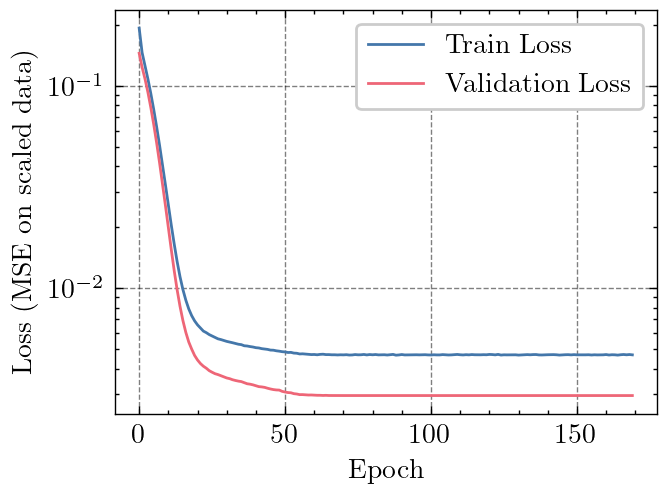

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_ylabel('Loss (MSE on scaled data)')
ax.set_xlabel('Epoch')
ax.set_yscale('log')
ax.legend()

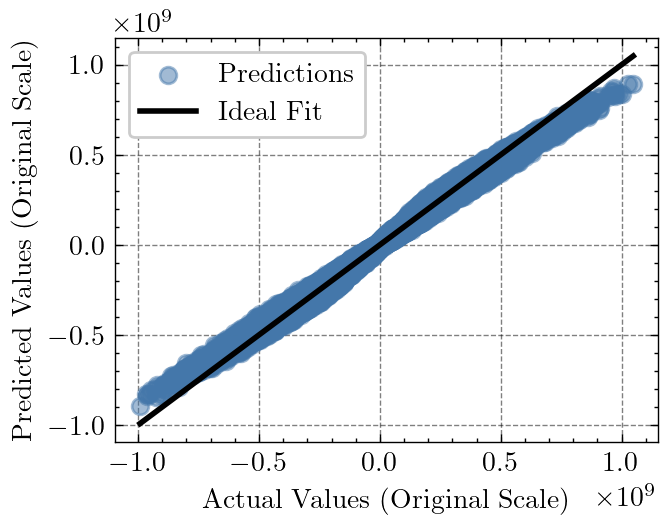

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'black', linewidth=2, label='Ideal Fit')
ax.set_xlabel("Actual Values (Original Scale)")
ax.set_ylabel("Predicted Values (Original Scale)")
ax.legend()

# Surrogate Model

In [205]:
def get_transfer_coeff(n):
    topo = {"Nx": n, "Ny": n,
            "e_pos" : [[0,0], [int((n-1)/2),0], [n-1,0], [0,int((n-1)/2)],
                       [0,n-1], [n-1,int((n)/2)], [int((n)/2),(n-1)], [n-1,n-1]],
            "electrode_type" : ['constant']*8}
    sim_class = Simulation(topology_parameter=topo, pack_optimizer=False)
    sim_class.build_conductance_matrix()
    sim_class.init_transfer_coeffs()
    return sim_class.get_transfer_coeffs()

In [ ]:
N_PARTICLES = 9
N_E         = 8
V_ON        = 0.002
V_OFF       = 0.0
V_RANGE     = 0.01
INPUT_POS   = [1,3]
SCALE       = False
INPUT_COL   = [f"E{INPUT_POS[0]}",f"E{INPUT_POS[1]}"]
N_SAMPLES   = 5000
TOPO        = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
                "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
                [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
                [N_PARTICLES-1,int((N_PARTICLES)/2)],
                [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
                "electrode_type" : ['constant']*N_E}

In [207]:
voltages        = logic_gate_sample(V_RANGE, INPUT_POS, N_SAMPLES, TOPO, V_ON, sample_technique='uniform')
if SCALE:
    t_coeff     = get_transfer_coeff(N_PARTICLES)
    factor      = np.ones_like(t_coeff, dtype=float)
    np.divide(t_coeff[INPUT_POS[0]], t_coeff, out=factor, where=t_coeff!=0)
    voltages    *= np.hstack((factor,0.0))
voltages        = voltages[:,:-2]
voltages_s      = x_scaler.transform(voltages)
current_data_s  = model.predict(voltages_s)
current_data    = y_scaler.inverse_transform(current_data_s).flatten()
data            = pd.DataFrame(np.hstack((voltages,current_data[:,np.newaxis],np.zeros(shape=(len(current_data),1)))),
                               columns=([f"E{i}" for i in range(7)]+['Observable','Error'])).round(6)
fitness_data    = fitness(df=data, input_cols=INPUT_COL, off_state=V_OFF, on_state=V_ON, delta=0)
abundance_data  = abundance(fitness_data)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step


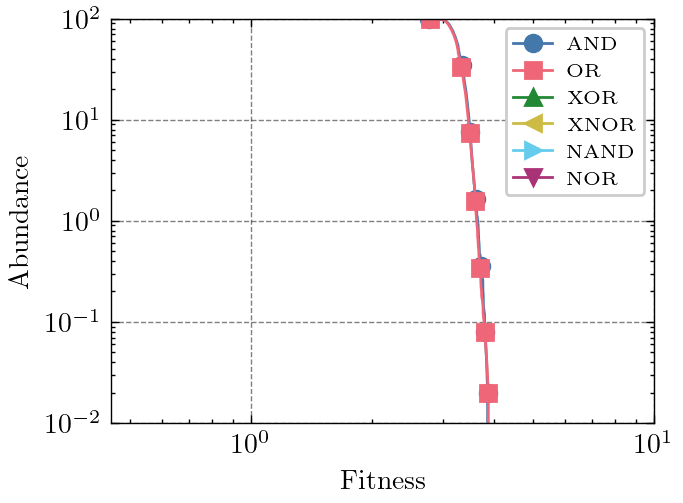

In [209]:
fig, ax = abundance_plot(abundance_data, y_limits=[0.01,100])